In [1]:
import logging
import os
import sys
import tempfile
from glob import glob


import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from PIL import Image, ImageDraw

from monai.visualize import plot_2d_or_3d_image
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple
from monai.transforms.utils import rescale_array


In [2]:
print(monai.__version__)

0.7.0


In [3]:
#monai.config.print_config()
#logging.basicConfig(stream=sys.stdout, level=logging.INFO)
tempdir = '/Users/sebastianotalora/work/postdoc/federated_learning/fedem/tmp_dir_circles/'
tempdir2 = '/Users/sebastianotalora/work/postdoc/federated_learning/fedem/tmp_dir_squares/'

# create a temporary directory and 40 random image, mask pairs
#print(f"generating synthetic data to {tempdir} (this may take a while)")
#for i in range(40):
#    im, seg = create_test_image_2d_squares(128, 128, num_seg_classes=1)
#    Image.fromarray((im * 255).astype("uint8")).save(os.path.join(tempdir, f"img{i:d}.png"))
#    Image.fromarray((seg * 255).astype("uint8")).save(os.path.join(tempdir, f"seg{i:d}.png"))

In [4]:
all_images = sorted(glob(os.path.join(tempdir, "img*.png"))) + sorted(glob(os.path.join(tempdir2, "img*.png")))
all_segs   = sorted(glob(os.path.join(tempdir, "seg*.png"))) + sorted(glob(os.path.join(tempdir2, "seg*.png")))


In [5]:
random_shuffle = np.random.permutation((len(all_images)))
all_images = [all_images[i] for i in random_shuffle]
all_segs = [all_segs[i] for i in random_shuffle]
print(all_images[-1])
print(all_segs[-1])

/Users/sebastianotalora/work/postdoc/federated_learning/fedem/tmp_dir_circles/img22.png
/Users/sebastianotalora/work/postdoc/federated_learning/fedem/tmp_dir_circles/seg22.png


In [6]:
#setup using both circles and squares
images_circles = sorted(glob(os.path.join(tempdir, "img*.png")))
segs_circles   = sorted(glob(os.path.join(tempdir, "seg*.png")))

images_squares = sorted(glob(os.path.join(tempdir2, "img*.png")))
segs_squares   = sorted(glob(os.path.join(tempdir2, "seg*.png")))

ext_val_both_imgs = images_circles[-20:] + images_squares[-20:]
ext_val_both_segm = images_squares[-20:] + segs_squares[-20:]


In [7]:
print(len(images_circles),len(segs_circles))

40 40


In [8]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

In [9]:
val_imtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

# define array dataset, data loader
check_ds = ArrayDataset(images_squares + images_circles, train_imtrans, segs_squares + segs_circles, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


In [10]:
# create a training data loader
train_ds = ArrayDataset(all_images[0:-20], train_imtrans, all_segs[0:-20], train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())
# create a validation data loader
val_ds = ArrayDataset(all_images[-20:], val_imtrans, all_segs[-20:], val_segtrans)
#ext_val_ds = ArrayDataset(ext_val_images, val_imtrans, ext_val_segs, val_segtrans)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
best_val_performances = []

for run_num in range(10):
    print(f"Training for run {run_num}")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    writer = SummaryWriter()
    for epoch in range(10):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    #print("========")
                    #print(val_outputs[0].shape,val_labels[0].shape)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    #print("========")

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
    best_val_performances.append(best_metric)

Training for run 0
----------
epoch 1/10
1/15, train_loss: 0.4429
2/15, train_loss: 0.4873
3/15, train_loss: 0.3751
4/15, train_loss: 0.3323
5/15, train_loss: 0.4555
6/15, train_loss: 0.2979
7/15, train_loss: 0.3273
8/15, train_loss: 0.2843
9/15, train_loss: 0.3348
10/15, train_loss: 0.3477
11/15, train_loss: 0.3819
12/15, train_loss: 0.3290
13/15, train_loss: 0.3495
14/15, train_loss: 0.3908
15/15, train_loss: 0.3176
epoch 1 average loss: 0.3636
----------
epoch 2/10
1/15, train_loss: 0.2822
2/15, train_loss: 0.3320
3/15, train_loss: 0.3194
4/15, train_loss: 0.2958
5/15, train_loss: 0.3513
6/15, train_loss: 0.3801
7/15, train_loss: 0.2519
8/15, train_loss: 0.3233
9/15, train_loss: 0.3288
10/15, train_loss: 0.2701
11/15, train_loss: 0.2784
12/15, train_loss: 0.3197
13/15, train_loss: 0.2529
14/15, train_loss: 0.2840
15/15, train_loss: 0.3110
epoch 2 average loss: 0.3054
saved new best metric model
current epoch: 2 current mean dice: 0.8717 best mean dice: 0.8717 at epoch 2
----------
e

epoch 7 average loss: 0.2162
----------
epoch 8/10
1/15, train_loss: 0.2039
2/15, train_loss: 0.2047
3/15, train_loss: 0.1936
4/15, train_loss: 0.1816
5/15, train_loss: 0.1567
6/15, train_loss: 0.1835
7/15, train_loss: 0.1692
8/15, train_loss: 0.2261
9/15, train_loss: 0.1852
10/15, train_loss: 0.2539
11/15, train_loss: 0.2272
12/15, train_loss: 0.3044
13/15, train_loss: 0.1734
14/15, train_loss: 0.1741
15/15, train_loss: 0.2210
epoch 8 average loss: 0.2039
saved new best metric model
current epoch: 8 current mean dice: 0.9834 best mean dice: 0.9834 at epoch 8
----------
epoch 9/10
1/15, train_loss: 0.2404
2/15, train_loss: 0.1939
3/15, train_loss: 0.2342
4/15, train_loss: 0.2210
5/15, train_loss: 0.1905
6/15, train_loss: 0.2392
7/15, train_loss: 0.1814
8/15, train_loss: 0.2060
9/15, train_loss: 0.1596
10/15, train_loss: 0.1604
11/15, train_loss: 0.1653
12/15, train_loss: 0.1808
13/15, train_loss: 0.2002
14/15, train_loss: 0.2048
15/15, train_loss: 0.1855
epoch 9 average loss: 0.1975
--

In [ ]:
### print(val_outputs[0].shape, val_labels.shape)

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

In [ ]:
plt.imshow(val_outputs[0][0].numpy())

In [ ]:
plt.imshow(val_labels[0][0].numpy())

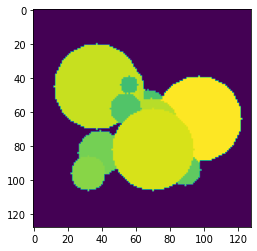

In [16]:
plt.imshow(val_images[0][0].numpy())